In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [101]:
# 2. Charger les données
# Charger les données prétraitées

df = pd.read_csv("../datasets/Month_Value_1.csv", parse_dates=True, index_col=0)

# S'assurer que l'index est une colonne de type datetime
df.index = pd.to_datetime(df.index)

df.dropna(inplace=True)

# Identifier les colonnes cibles (toutes sauf la date)
target_column = df.columns[-1]

feature_columns = [col for col in df.columns if col != target_column] if len(df.columns) > 1 else [target_column]
# Dictionnaire pour stocker les prédictions
forecast_results = {}
feature_columns
df.loc[:,feature_columns]


,Revenue,Sales_quantity,Average_cost
Period,,,
2015-01-01,1.601007e+07,12729.0,1257.763541
2015-01-02,1.580759e+07,11636.0,1358.507000
2015-01-03,2.204715e+07,15922.0,1384.697024
2015-01-04,1.881458e+07,15227.0,1235.606705
2015-01-05,1.402148e+07,8620.0,1626.621765
...,...,...,...
2019-01-12,5.875647e+07,38069.0,1543.420464
2020-01-01,5.628830e+07,27184.0,2070.640850
2020-01-02,4.022524e+07,23509.0,1711.057181


In [102]:
# 3. Normalisation des données
# LSTM fonctionne mieux avec des données normalisées entre 0 et 1 :
scalers = {}
scaled_data = {}

scalers = {}

for column in df.columns:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data[column] = scaler.fit_transform(df[[column]])
    scaled_data[column] = scaled_data[column].flatten()
    scalers[column] = scaler

scaled_data = pd.DataFrame(scaled_data, index= df.index)
scaled_data
X = scaled_data.loc[:,feature_columns]
y=scaled_data.loc[:,target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# scaler_X = MinMaxScaler(feature_range=(0, 1))
# scaler_y = MinMaxScaler(feature_range=(0, 1))

# # Fit scaler on training data only
# X_train_scaled = scaler_X.fit_transform(X_train)
# y_train_scaled = scaler_X.transform(pd.DataFrame(y_train))
# # y_train_scaled = scaler_y.fit_transform(pd.DataFrame(y_train))

# # Transform test data with the same scaler
# X_test_scaled = scaler_X.transform(X_test)
# y_test_scaled = scaler_X.transform(pd.DataFrame(y_test))

y_train


Period
2015-01-01    1.000000
2015-01-02    1.000000
2015-01-03    1.000000
2015-01-04    1.000000
2015-01-05    1.000000
2015-01-06    1.000000
2015-01-07    1.000000
2015-01-08    1.000000
2015-01-09    1.000000
2015-01-10    1.000000
2015-01-11    1.000000
2015-01-12    1.000000
2016-01-01    0.161217
2016-01-02    0.161217
2016-01-03    0.161217
2016-01-04    0.161217
2016-01-05    0.161217
2016-01-06    0.161217
2016-01-07    0.161217
2016-01-08    0.161217
2016-01-09    0.161217
2016-01-10    0.161217
2016-01-11    0.161217
2016-01-12    0.161217
2017-01-01    0.000000
2017-01-02    0.000000
2017-01-03    0.000000
2017-01-04    0.000000
2017-01-05    0.000000
2017-01-06    0.000000
2017-01-07    0.000000
2017-01-08    0.000000
2017-01-09    0.000000
2017-01-10    0.000000
2017-01-11    0.000000
2017-01-12    0.000000
2018-01-01    0.302258
2018-01-02    0.302258
2018-01-03    0.302258
2018-01-04    0.302258
2018-01-05    0.302258
2018-01-06    0.302258
2018-01-07    0.302258
2018

In [103]:
# 4. Transformer les données en séquences pour LSTM
def create_sequences(data, seq_length=12):
    sequences = []
    for i in range(len(data) - seq_length +1):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

#seq_length: Nombre de pas de temps utilisés pour la prédiction
detected_freq = pd.infer_freq(df.index)
print("***",detected_freq,"***")
if detected_freq in ["D", "B"]:  # Quotidienne ou Business Days
    seq_length = 10
elif detected_freq in ["MS", "M"]:# "justify your choices"
    seq_length = 12
else:
    seq_length = 1
print(seq_length)
# Dictionnaire pour stocker les séquences

X_train_seq = create_sequences(X_train, seq_length=seq_length)
y_train_seq = create_sequences(y_train, seq_length=seq_length)
X_test_seq = create_sequences(X_test, seq_length=seq_length)
y_test_seq = create_sequences(y_test, seq_length=seq_length)


*** None ***
1


In [104]:
# 6. Définir l'architecture du modèle LSTM
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(200, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(200, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_lstm_model_2():
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


In [105]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model = build_lstm_model((X_train_seq.shape[1], X_train_seq.shape[2]))
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

train_loss = model.evaluate(X_train_seq, y_train_seq, verbose=0)
test_loss = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Make predictions
predictions = model.predict(X_test_seq)
predictions

Epoch 1/100


C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 409ms/step - loss: 0.3416 - val_loss: 0.3001
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.3254 - val_loss: 0.2912
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3002 - val_loss: 0.2819
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.3039 - val_loss: 0.2716
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2972 - val_loss: 0.2603
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2914 - val_loss: 0.2480
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2736 - val_loss: 0.2346
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2667 - val_loss: 0.2200
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2682 - val_loss: 0.2042
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.2595 - val_loss: 0.1878
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2593 - val_loss: 0.1715
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2346 - val_loss: 0.1553


array([[0.39595622],
       [0.385077  ],
       [0.4297688 ],
       [0.4202876 ],
       [0.41109422],
       [0.42749122],
       [0.42940077],
       [0.40195504],
       [0.49930188],
       [0.45055148],
       [0.41288748],
       [0.46209744],
       [0.44211692]], dtype=float32)

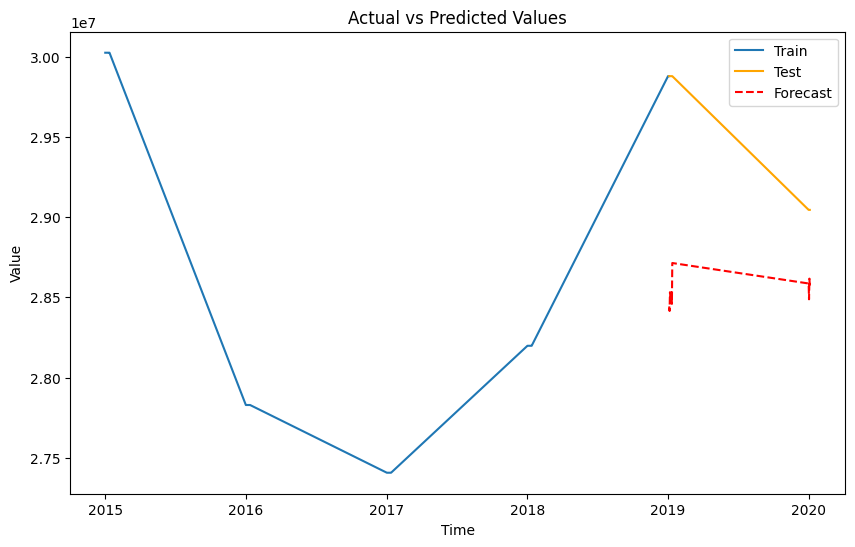

In [106]:
y_test_rescaled = scalers[target_column].inverse_transform(y_test.values.reshape(-1, 1))  # For actual values
y_pred_rescaled = scalers[target_column].inverse_transform(predictions)
y_train_rescaled = scalers[target_column].inverse_transform(y_train.values.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train_rescaled, label="Train")
plt.plot(y_test.index, y_test_rescaled, label="Test", color="orange")
plt.plot(y_test.index, y_pred_rescaled, label="Forecast", linestyle="dashed", color="red")
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
y_test_rescaled

(13, 1)

-8.252588394489575

In [109]:
# # 7. Entraîner un modèle LSTM par colonne
# for column in target_columns:
#     print(f"Training LSTM model for {column}...")

#     X_train, y_train = train_sequences[column]
#     X_test, y_test = test_sequences[column]

#     # Construire et entraîner le modèle
#     model = build_lstm_model((seq_length, 1))
#     model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=1)

#     # Faire des prédictions
#     y_pred = model.predict(X_test)

#     # Inverser la normalisation
#     y_pred_rescaled = scalers[column].inverse_transform(y_pred)
#     y_test_rescaled = scalers[column].inverse_transform(y_test)

#     # Calculer l'erreur
#     mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
#     print(f"MSE for {column}: {mse:.4f}")

#     # Sauvegarder les résultats
#     forecast_results[column] = pd.DataFrame({
#         "ds": df.index[train_size + seq_length:],
#         "yhat": y_pred_rescaled.flatten()
#     })

#     # Visualisation
#     plt.figure(figsize=(10, 5))
#     plt.plot(df.index[:train_size], df[column][:train_size], label="Train")
#     plt.plot(df.index[train_size:], df[column][train_size:], label="Test", color="orange")
#     plt.plot(df.index[train_size + seq_length:], y_pred_rescaled, label="Forecast", linestyle="dashed", color="red")
#     plt.title(f"Prédictions LSTM pour {column}")
#     plt.legend()
#     plt.show()

# # Sauvegarder les prévisions
# for col, forecast in forecast_results.items():
#     forecast.to_csv(f"forecast_lstm_{col}.csv", index=False)

# print("Toutes les prédictions LSTM ont été enregistrées.")